In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from pandas import read_pickle
import pickle
from keras.models import model_from_json

# test datasets
from toy_data import Two2DGaussians
from toy_data import TwoAlternating2DGaussians
from toy_data import TwoLinearDynamicalSystems
from motion_data import MotionCaptureData
from coffee_shop_world_data import CoffeeShopWorldData

# hack to import model from parent directory
# TODO fix with proper modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerPerceptron
from models import KerasSimpleRNN, KerasGRU
from opt.utils import evaluate, randstr


Using TensorFlow backend.


In [33]:
# Show summary statistics

res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_None_summary.pkl')



# Test summary results

TL;DR Some generalization on coffee shop world with default SEM parameters, vanilla HRRs, and little pretraining, with a **uniform prior** (i.e. maximum likelihood estimation instead of MAP).

## Methods:

I ran Coffee Shop World with pretraining. For each test, I first pretrained SEM with a given number of n_iterations (as defined in the Coffee Shop World engine) with n_repeats = 2 for each iteration, with the poetry and fight schemas. So basically data generated by:

```
python run_engine.py poetry fight [n_iterations] 2
```

So 1 iteration = `[poetry event, fight event, poetry event, fight event]`.

During pretraining, I give the model the correct event labels (e.g. `[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 ...]`) so it can learn the "correct" event models.

Then I ran this pretrained SEM on a separate data set with n_iterations = 20, i.e. 

```
python run_engine.py poetry fight 20 2
```

I did this separately for different values of n_iterations (and different SEM objects obviously).

I used "vanilla" HRRs, as defined in Tony Plate's paper (without any of the stuff Jerry did). The parameters of each separate run can be found further below.

I also used a uniform prior instead of the CRP prior. I wanted to see how maximum likelihood estimation does.

## Results:

Here I'm plotting how well SEM did depending on how much pretraining it received. Surprisingly, it did well in some cases when it got little training, but not when it got more training. Of course this is just qualitative, since I only have 6 data points here.

## Next up:

I realized I'm still generating the coffee shop world stories with the same seed, which might create repeated stories even for different parameters. Although it doesn't seem like it by inspecting the data (see below for "pretraining with params 4, 2, 400")

I'll fix that, and run it again, also with more simulations for each value of n_iterations since obviously whether pretraining converges on correct models or not is stochastic.

[2, 4, 8, 10, 40, 80]


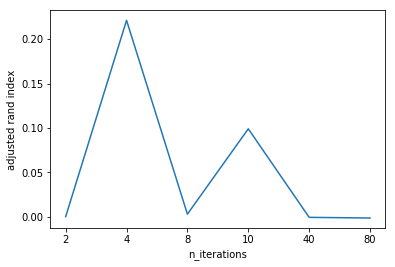

In [34]:
t = res['tests_to_run']

x = [x[1][0] if x[1] else 0 for x in t]

#x[0] = 1
print x
rs = res['rs']
plt.plot(range(len(rs)), rs)
#plt.xscale('log')
plt.xticks(range(len(rs)), x)
plt.xlabel('n_iterations')
plt.ylabel('adjusted rand index')
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 2, 2, 400


In [3]:
# Ensure reproducibility
#
np.random.seed(0)


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

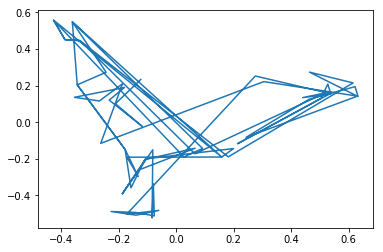

In [4]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

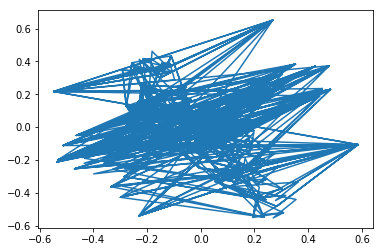

In [5]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [6]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [7]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [8]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [9]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_0_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_NJL8WLBHC0/event_model_weights_G4LLD7B5XM.h5
       loading event model 1  from  output_NJL8WLBHC0/event_model_weights_Q4LEZ80ODK.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  7.16739011e-02  -8.69793132e-02  -5.03562376e-02  -9.46731116e-02
  -2.52340366e-02  -4.72714375e-02   2.63390713e-03   9.74999310e-02
  -5.95711000e-02  -3.71690757e-02   4.02781887e-02  -3.61946461e-02
   5.56951109e-02   8.27585225e-02   2.04398440e-02   1.37706816e-02
  -1.2846

In [10]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [11]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_0.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000067e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

       loading event model 0  from  output_NJL8WLBHC0/event_model_weights_BVJ3Z50A9I.h5
       loading event model 1  from  output_NJL8WLBHC0/event_model_weights_OXFIO4PGG6.h5
       loading event model 2  from  output_NJL8WLBHC0/event_model_weights_7IG4QHF2T4.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.07448472 -0.05911329 -0.01269132 -0.09130526  0.00253663  0.04446626
 -0.04433888 -0.03398164 -0.05653006 -0.0345076  -0.00739372  0.02885842
 -0.01500025 -0.03799857  0.0311898  -0.0014032  -0.01033575  0.01761916
  0.07148986  0.08863903 -0.03863828 -0.04979665  0.04487804  0.06381348
 -0.06444972  0.00382635 -0.0609347   0.01805111  0.00476887 -0.02319435
  0.08058454 -0.00383215  0.0

In [12]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -1.83031722911e-15
Adjusted Rand Score: 0.0

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

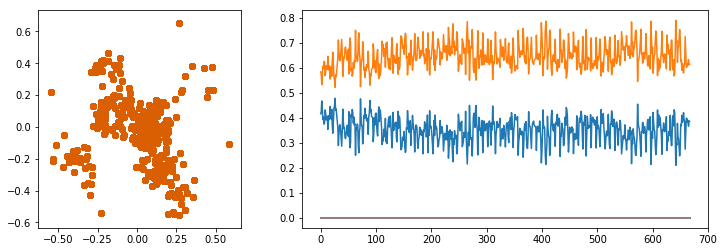

In [15]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


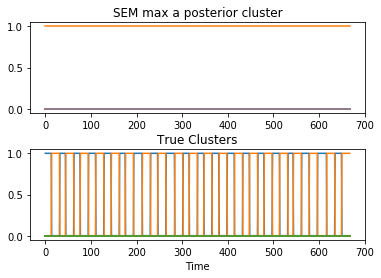

In [14]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 4, 2, 400


In [16]:
# Ensure reproducibility
#
np.random.seed(0)


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

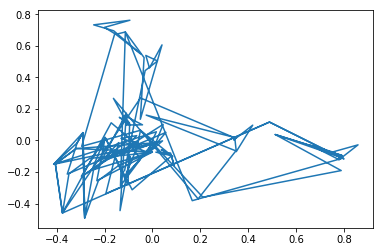

In [17]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

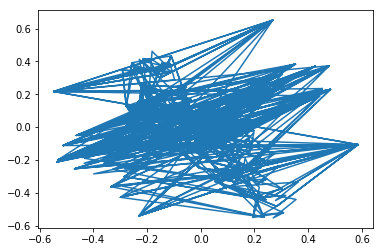

array([[ 0.05722255,  0.04705204,  0.04476536, -0.02142319,  0.02154438,
         0.02636746,  0.00260051, -0.04731178, -0.02257824],
       [-0.04048454, -0.05466528, -0.05848587,  0.00291064, -0.05870159,
         0.02162554, -0.04864169,  0.0899001 , -0.06786172],
       [ 0.01812558, -0.09200297, -0.06960369, -0.01355235,  0.03343837,
        -0.01560026, -0.03949292,  0.04265488, -0.04976255],
       [-0.02861435, -0.0374566 ,  0.0268197 ,  0.03765141,  0.02386932,
         0.01247991,  0.01974975, -0.002627  , -0.03212124],
       [ 0.02548556, -0.00045421,  0.01165296, -0.02296845,  0.01096447,
         0.02824238, -0.00693974, -0.02755638,  0.02654031],
       [-0.04291572, -0.05153169,  0.03847339,  0.02313055, -0.01170323,
         0.03729531, -0.00082328, -0.04889657,  0.02353628],
       [-0.00087783, -0.08917501, -0.03848115, -0.02040494,  0.00904493,
        -0.05675594,  0.02341099,  0.05636073,  0.05183797],
       [ 0.01467672, -0.0133617 , -0.02010735, -0.07593865,  0

In [20]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()



[[ 0.00828978  0.08052655  0.00225008 -0.08338211 -0.00218667 -0.00295078
  -0.02127578  0.00405269 -0.05393426]
 [ 0.05196788 -0.00172949 -0.03730329 -0.00551775 -0.03560858 -0.0329056
   0.01545056  0.03185202 -0.04230356]
 [ 0.066937    0.01361451  0.02422602  0.007224    0.02616359  0.00609649
   0.0676321   0.03175664 -0.09086589]
 [-0.00122754  0.02779353  0.01153294 -0.04331754 -0.0327047   0.01730232
   0.04961819 -0.04069873 -0.02655907]
 [ 0.0337351   0.0689913   0.05848533 -0.08339131 -0.04684809  0.02956811
   0.01681429  0.00826591 -0.02995064]
 [-0.03913823  0.02423862  0.11662792  0.01642827 -0.00844894  0.07154115
  -0.0217534  -0.03821609  0.01981789]
 [ 0.05130122  0.0880313   0.05049287  0.06590602 -0.03371005  0.00306217
  -0.03177968 -0.00861358  0.0753716 ]
 [ 0.02703705  0.05026118  0.02461927  0.07246438  0.02277878  0.00492369
  -0.0422753   0.01760217  0.03064043]
 [-0.01324852  0.04772852 -0.04008598  0.0574566   0.03975577  0.00035239
  -0.04288162  0.074607

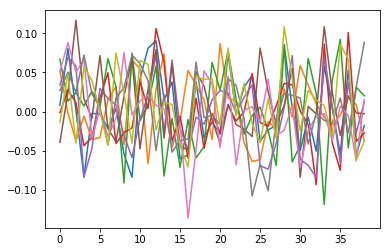

[[ 0.05722255  0.04705204  0.04476536 -0.02142319  0.02154438  0.02636746
   0.00260051 -0.04731178 -0.02257824]
 [-0.04048454 -0.05466528 -0.05848587  0.00291064 -0.05870159  0.02162554
  -0.04864169  0.0899001  -0.06786172]
 [ 0.01812558 -0.09200297 -0.06960369 -0.01355235  0.03343837 -0.01560026
  -0.03949292  0.04265488 -0.04976255]
 [-0.02861435 -0.0374566   0.0268197   0.03765141  0.02386932  0.01247991
   0.01974975 -0.002627   -0.03212124]
 [ 0.02548556 -0.00045421  0.01165296 -0.02296845  0.01096447  0.02824238
  -0.00693974 -0.02755638  0.02654031]
 [-0.04291572 -0.05153169  0.03847339  0.02313055 -0.01170323  0.03729531
  -0.00082328 -0.04889657  0.02353628]
 [-0.00087783 -0.08917501 -0.03848115 -0.02040494  0.00904493 -0.05675594
   0.02341099  0.05636073  0.05183797]
 [ 0.01467672 -0.0133617  -0.02010735 -0.07593865  0.0383101   0.09879839
   0.01594504 -0.05543612  0.03449634]
 [-0.01873326  0.04059037 -0.00505907 -0.0294686   0.01222394  0.01481268
   0.01932241 -0.10316

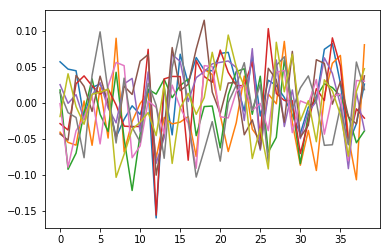

In [38]:
print pretrain_data.X[1:10, 1:10]

plt.plot(pretrain_data.X[1:10,1:40].transpose())
plt.show()

print test_data.X[1:10,1:10]

plt.plot(test_data.X[1:10,1:40].transpose())
plt.show()


In [23]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [24]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [25]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [26]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_1_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_NJL8WLBHC0/event_model_weights_DIN7ASC8TB.h5
       loading event model 1  from  output_NJL8WLBHC0/event_model_weights_UZHOMZIZRL.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  7.47811276e-02  -3.31955642e-02  -2.72732702e-02   1.47960401e-02
  -1.71217076e-02  -4.06866434e-02   1.61171631e-02  -7.76041080e-02
   3.28976343e-02   1.24505229e-02  -9.39217430e-03  -7.54433093e-02
   3.67490969e-02   5.19549778e-02  -8.68634720e-02  -1.57316330e-02
   2.8372

In [27]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [28]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_1.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000013e+09   1.00000054e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

       loading event model 0  from  output_NJL8WLBHC0/event_model_weights_JTT5TN9OOI.h5
       loading event model 1  from  output_NJL8WLBHC0/event_model_weights_UX7X54JET0.h5
       loading event model 2  from  output_NJL8WLBHC0/event_model_weights_7LT9V7QOR3.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.07448472 -0.05911329 -0.01269132 -0.09130526  0.00253663  0.04446626
 -0.04433888 -0.03398164 -0.05653006 -0.0345076  -0.00739372  0.02885842
 -0.01500025 -0.03799857  0.0311898  -0.0014032  -0.01033575  0.01761916
  0.07148986  0.08863903 -0.03863828 -0.04979665  0.04487804  0.06381348
 -0.06444972  0.00382635 -0.0609347   0.01805111  0.00476887 -0.02319435
  0.08058454 -0.00383215  0.0

In [29]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.263197659132
Adjusted Rand Score: 0.22131811667

[1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 0 1 1 1 1 1 1

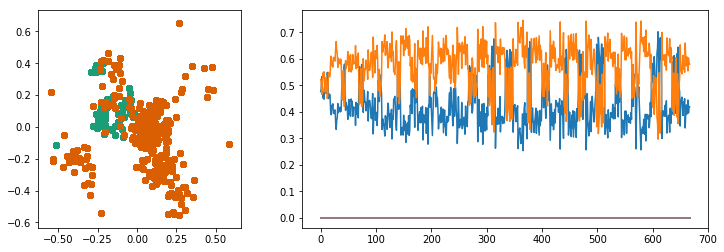

In [30]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


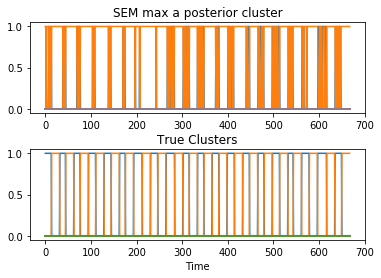

In [31]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 8, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_2_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_2.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 10, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_3_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_3.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 40, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_4_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_4.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 80, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(80,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_5_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_NJL8WLBHC0/test_results_NJL8WLBHC0_5.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()
